In [3]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from skimage.util import view_as_windows

from framework.pixelhop import *
from framework.utils import *

from skimage.measure import block_reduce
import xgboost as xgb
import warnings, gc
import time
import matplotlib.pyplot as plt

from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.__version__)

import os
print(os.getcwd())

from framework.dftloss import *

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn

from xgboost import XGBClassifier

True
1
1.13.0
/media/hongyu/SSD/SSDUBUNTU/WUSL/Pixelhop-Pytorch


In [4]:
# ---------- Load MNIST data and split ----------
(x_train, y_train), (x_test,y_test) = cifar10.load_data()
# -----------Data Preprocessing-----------
x_train = np.asarray(x_train,dtype='float32')
x_test = np.asarray(x_test,dtype='float32')
y_train = np.asarray(y_train,dtype='int')
y_test = np.asarray(y_test,dtype='int')
print("training with input:", x_train.shape)

# brutal force flip augmentation of trianing data:
Xtrain = []
for img in x_train:
    
    imgflip = cv2.flip(img,1)
    Xtrain.append(imgflip)
    
Xtrain = np.array(Xtrain)
print(Xtrain.shape)

Xtrain = np.concatenate((Xtrain,x_train),axis=0)
print(Xtrain.shape)

Ytrain = np.concatenate((y_train,y_train),axis=0)

training with input: (50000, 32, 32, 3)
(50000, 32, 32, 3)
(100000, 32, 32, 3)


In [2]:
module_filename = './model/model_d=535.pkl'
mymodel = pickle.load(open(module_filename ,'rb'))
print("model loaded at ", module_filename)

model loaded at  ./model/model_d=535.pkl


In [ ]:
t0 = time.time()

feattrain = mymodel.transform(Xtrain)[-3] #hop -1
# feattrain = mymodel.transform(Xtrain)[-2] # hop -2 5x5
feattrain = feattrain.reshape(feattrain.shape[0],-1)
print(feattrain.shape, Ytrain.shape)

feattest = mymodel.transform(x_test)[-3]  #hop -1
# feattest = mymodel.transform(x_test)[-2] # hop -2 5x5
feattest = feattest.reshape(feattest.shape[0],-1)
print(feattest.shape, y_test.shape)

print("extraction time:", time.time() - t0)

In [5]:
feature_filename = './model/feat_train+test_d=535.pkl'
feat_load = pickle.load(open(feature_filename ,'rb'))
feattrain, feattest = feat_load

print(feattrain.shape)
print(feattest.shape)

(100000, 535)
(10000, 535)


In [6]:


# xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
#                             num_class=3, 
#                             missing=1, 
#                             early_stopping_rounds=10, 
xgb_model = XGBClassifier(n_estimators = 2000, \
                            learning_rate=0.2,\
                            max_depth=5,\
                            num_class=10,\
                            objective='multi:softmax', \
                            tree_method='gpu_hist', \
                            gpu_id=0).fit(feattrain, Ytrain)

/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(10000,)
Test Accuary: 71.56%


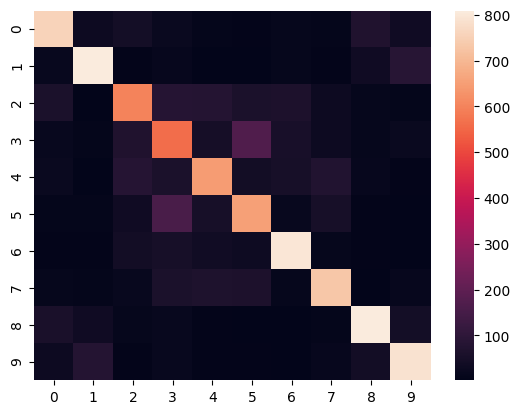

In [11]:
t0 = time.time()
y_test_preds = []
y_test_preds = xgb_model.predict(feattest)
print(y_test_preds.shape)


pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))
# print('inference time:', time.time() - t0)

cnf_matrix = confusion_matrix(y_test, y_test_preds)
df_cm = pd.DataFrame(cnf_matrix)
sn.heatmap(df_cm)
plt.show()

In [1]:
import pickle
xgb_dir = './model/xgb_hop3.pkl'

# pickle.dump(xgb_model ,open(xgb_dir ,'wb'))
xgb_model = pickle.load(open(xgb_dir ,'rb'))

In [31]:
from hummingbird.ml import convert, load

input = np.random.rand(10, 535)
# pytorch_model = convert(xgb_model, 'pytorch', input)
pytorch_model = convert(xgb_model, 'pytorch', input, device='cuda')


In [32]:
xgb_pytorch = pytorch_model
print(xgb_pytorch.model.parameters)

<bound method Module.parameters of Executor(
  (_operators): ModuleList(
    (0): PerfectTreeTraversalGBDTImpl(
      (nodes): ParameterList(
          (0): Parameter containing: [torch.int64 of size 40000 (GPU 0)]
          (1): Parameter containing: [torch.int64 of size 80000 (GPU 0)]
          (2): Parameter containing: [torch.int64 of size 160000 (GPU 0)]
          (3): Parameter containing: [torch.int64 of size 320000 (GPU 0)]
      )
      (biases): ParameterList(
          (0): Parameter containing: [torch.float32 of size 40000 (GPU 0)]
          (1): Parameter containing: [torch.float32 of size 80000 (GPU 0)]
          (2): Parameter containing: [torch.float32 of size 160000 (GPU 0)]
          (3): Parameter containing: [torch.float32 of size 320000 (GPU 0)]
      )
    )
  )
)>


In [33]:
from hummingbird.ml._executor import Executor
print(xgb_pytorch.model.__class__)
print(xgb_pytorch.model.__class__.__name__)

<class 'hummingbird.ml._executor.Executor'>
Executor


In [36]:
torch.cuda.empty_cache()

In [35]:
feattest_cuda = torch.FloatTensor(feattest)
feattest_cuda = feattest_cuda.to('cuda')
# verify the converted model:
y_test_preds = xgb_pytorch.predict(feattest)
print(y_test_preds.shape)
pred_accuracy_score = accuracy_score(y_test, y_test_preds)
# pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print("Test Accuary: %.2f%%" % (pred_accuracy_score* 100.0))


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 7.77 GiB total capacity; 5.45 GiB already allocated; 831.50 MiB free; 5.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [13]:
import pickle
xgbpytorch_dir = './model/xgb_pytorch.pkl'

pickle.dump(xgb_pytorch,open(xgbpytorch_dir ,'wb'))
# xgb_pytorch.save("xgb_pytorch")

In [80]:
# deepspeed.profiling.flops_profiler.profiler.get_model_profile(model, \
    # input_shape=None, args=[], kwargs={}, print_profile=True, detailed=True,\
        # module_depth=-1, top_modules=1, warm_up=1, as_string=True, output_file=None, ignore_modules=None)
from deepspeed.profiling.flops_profiler.profiler import get_model_profile

batch_size = 1
flops, macs, params = get_model_profile(model=pytorch_model.model, input_shape=(batch_size, 535))


-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per gpu:                                               1.9 M   
params of model = params per GPU * mp_size:                   1.9 M   
fwd MACs per GPU:                                             0 MACs  
fwd flops per GPU:                                            0       
fwd flops of model = fwd flops per GPU * mp_size:             0       
fwd latency:                                                  779.39 us
fwd FLOPS per GPU = fwd flops per GPU / fwd latency:      

In [81]:

from pthflops import count_ops

# Create a network and a corresponding input
device = 'cuda:0'
model = pytorch_model.model
inp = torch.rand(1,535).to(device)

test = model(inp)
print(test)

(tensor([6], device='cuda:0'), tensor([[7.3612e-02, 4.2954e-05, 1.8645e-03, 6.2914e-02, 6.5400e-03, 3.0134e-04,
         8.1835e-01, 3.0043e-05, 3.6346e-02, 1.9313e-06]], device='cuda:0'))


In [76]:
# deepspeed.profiling.flops_profiler.profiler.FlopsProfiler
from deepspeed.profiling.flops_profiler.profiler import FlopsProfiler as FP

model = pytorch_model.model
prof = FP(model)
device = 'cuda:0'
inp = torch.rand(1,535).to(device)
prof.start_profile()

model(inp)

flops = prof.get_total_flops(as_string=True)
params = prof.get_total_params(as_string=True)
prof.print_model_profile()
prof.end_profile()



-------------------------- DeepSpeed Flops Profiler --------------------------
Profile Summary at step 1:
Notations:
data parallel size (dp_size), model parallel size(mp_size),
number of parameters (params), number of multiply-accumulate operations(MACs),
number of floating-point operations (flops), floating-point operations per second (FLOPS),
fwd latency (forward propagation latency), bwd latency (backward propagation latency),
step (weights update latency), iter latency (sum of fwd, bwd and step latency)

params per gpu:                                               1.9 M   
params of model = params per GPU * mp_size:                   1.9 M   
fwd MACs per GPU:                                             0 MACs  
fwd flops per GPU:                                            0       
fwd flops of model = fwd flops per GPU * mp_size:             0       
fwd latency:                                                  972.99 us
fwd FLOPS per GPU = fwd flops per GPU / fwd latency:      

In [87]:
from torchprofile import profile_macs

model = pytorch_model.model
inputs = torch.rand(1,535)
macs = profile_macs(model, inputs)

from thop import clever_format
macs = clever_format([macs], "%.3f")
print(macs)

80.000K


/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::index_select". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gather". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/hongyu/anaconda3/envs/saab/lib/python3.8/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::argmax". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
